In [1]:
from __future__ import division, print_function, unicode_literals
import re
import logging
import operator
import itertools
from collections import Counter
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.gridspec as mgridspec
plt.style.use('newsprint.mplstyle')

In [7]:
logging.basicConfig(level=logging.INFO)

In [8]:
# local modules
from presidents import logger, parse_date, tzinfos
from presidents.readers import read_ldjson
from presidents.analysis.text import standard_stopwords, tokenize, nlp, parse, is_word
# import presidents.analysis.speeches
# reload(presidents.analysis.speeches)
from presidents.analysis.speeches import Speech

In [9]:
# mending plots
from adjustText import adjust_text

In [10]:
# from wordcloud import WordCloud

## Load speech groups

In [11]:
tapp_election_datapaths = ['tapp/election2016.json', 'tapp/election2012.json', 'tapp/election2008.json']
tapp_listing2016_datapaths = ['tapp/listing2016-{:02d}.json'.format(i) for i in range(1, 13)]
tapp_listing2017_datapaths = ['tapp/listing2017-{:02d}.json'.format(i) for i in range(1, 10)]
all_datapaths = [
    'tapp/inaugurals.json',
    'millercenter/speeches.json',
    'tapp/transition2017.json',
    'trump.json',
    'michael-anton.json',
] + tapp_election_datapaths + tapp_listing2016_datapaths + tapp_listing2017_datapaths

In [12]:
def iter_speeches(datapaths):
    for datapath in datapaths:
        for speech_dict in read_ldjson('../data/' + datapath):
            speech = Speech(**speech_dict)
            speech.datapath = datapath
            # a lot of 2012 speeches are just a YouTube video; exclude those
            if len(speech.text) > 0:
                yield speech
all_speeches = list(iter_speeches(all_datapaths))

### Notable dates

In [13]:
war_date = parse_date('1948-11-01', tzinfos['EST'])
inauguration_date = parse_date('2017-01-20', tzinfos['EST'])
first100days_date = parse_date('2017-04-29', tzinfos['EST'])

### Predicates for selecting speech subsets

In [14]:
is_prewar = lambda speech: speech.timestamp < war_date
is_postwar = lambda speech: speech.timestamp > war_date
is_preinauguration = lambda speech: speech.timestamp < inauguration_date
is_postinauguration = lambda speech: speech.timestamp >= inauguration_date
is_prefirst100days = lambda speech: speech.timestamp < first100days_date
is_postfirst100days = lambda speech: speech.timestamp >= first100days_date
is_trump = lambda speech: speech.author == 'Donald J. Trump'
isnt_trump = lambda speech: speech.author != 'Donald J. Trump'
is_obama = lambda speech: speech.author == 'Barack Obama'
is_tapp_inaugural = lambda speech: speech.datapath == 'tapp/inaugurals.json'
is_millercenter = lambda speech: speech.datapath == 'millercenter/speeches.json'
def is_campaign_speech(year):
    datapath = 'tapp/election{}.json'.format(year)
    return lambda speech: (speech.metadata.get('category') == 'campaign speeches' and 
                           speech.datapath == datapath)
is_transition2017 = lambda speech: speech.datapath == 'millercenter/speeches.json'
is_inoffice = lambda speech: not speech.datapath.startswith('tapp/election')

In [15]:
# (name, fullname, *predicates)
groupspecs = [
    ('inaugurals',                  'All inaugural addresses',
      is_tapp_inaugural),
    ('inaugurals_prewar',           'Pre-war inaugural addresses',
      is_tapp_inaugural, is_prewar),
    ('inaugurals_postwar_pretrump', 'Post-war, pre-Trump inaugural addresses',
      is_tapp_inaugural, is_postwar, isnt_trump),
    ('inaugurals_pretrump',         'All prior inaugural addresses',
      is_tapp_inaugural, isnt_trump),
    ('inaugurals_trump',            'Trump inaugural address',
      is_tapp_inaugural, is_trump),
    ('millercenter',                'All Miller Center speeches',
      is_millercenter),
    ('election2008_speeches',       'All 2008 campaign speeches',
      is_campaign_speech(2008)),
    ('election2012_speeches',       'All 2012 campaign speeches',
      is_campaign_speech(2012)),
    ('election2016_speeches',       'All 2016 campaign speeches',
      is_campaign_speech(2016)),
    ('election2016_speeches_trump', 'Trump campaign speeches',
      is_trump, is_campaign_speech(2016)),
    ('transition2017_trump',        'Transition 2017: Trump',
      is_trump, is_transition2017),
    ('transition2017_obama',        'Transition 2017: Obama',
      isnt_trump, is_transition2017),
    ('president_trump',                    'President Trump, in office',
      is_trump, is_inoffice),
    ('president_trump_preinauguration',    'President Trump, pre-inauguration',
      is_trump, is_preinauguration),
    ('president_trump_first100days',    'President Trump, 1st-100-days',
      is_trump, is_postinauguration, is_prefirst100days),
    ('president_trump_postfirst100days',    'President Trump, after 1st-100-days',
      is_trump, is_postfirst100days),
]

In [16]:
def speech_matches_predicates(speech, predicates):
    try:
        return all(predicate(speech) for predicate in predicates)
    except Exception:
        logger.error('Could not run predicates on speech: {}'.format(speech.metadata))
        raise

class Group(object):
    def __init__(self, name, fullname, *predicates):
        self.name = name
        self.fullname = fullname
        self.speeches = [speech for speech in all_speeches if speech_matches_predicates(speech, predicates)]

    def __len__(self):
        return len(self.speeches)
    
    def __repr__(self):
        return '<Group {} "{}" ({} speeches)>'.format(self.name, self.fullname, len(self))

    @property
    def description(self):
        return '{} ({})'.format(self.fullname, len(self))

In [17]:
groups = [Group(*groupspec) for groupspec in groupspecs]

In [18]:
groups_lookup = {group.name: group for group in groups}

In [19]:
def iter_groupinfos(groups):
    for group in groups:
        yield group.name, group.fullname, len(group)
pd.DataFrame(iter_groupinfos(groups), columns=['group_name', 'group_fullname', 'documents'])

,group_name,group_fullname,documents
0,inaugurals,All inaugural addresses,58
1,inaugurals_prewar,Pre-war inaugural addresses,40
2,inaugurals_postwar_pretrump,"Post-war, pre-Trump inaugural addresses",17
3,inaugurals_pretrump,All prior inaugural addresses,57
4,inaugurals_trump,Trump inaugural address,1
5,millercenter,All Miller Center speeches,962
6,election2008_speeches,All 2008 campaign speeches,686
7,election2012_speeches,All 2012 campaign speeches,281
8,election2016_speeches,All 2016 campaign speeches,383
9,election2016_speeches_trump,Trump campaign speeches,60


# Proportion of speech allocated to specific word groups

In [20]:
def create_group_synset_df(groups, synsets):
    '''
    groups are a list of (group_name, Group instance) pairs
    synsets is a list of (synset_name, synset_tokens) pairs
    '''
    def iter_group_synset_counts(groups, synsets):
        for group_name, group in groups:
            #collocation_mapping = dict(nlp.sentence_collocation_mapping(speech.document for speech in group.speeches))
            for speech in group.speeches:
                speech_counts = speech.lower_counts
                total_count = len(speech_counts.values())
                for synset_name, synset_tokens in synsets:
                    #synset_tokens = nlp.bootstrap_strings(synset_tokens, collocation_mapping, 10)
                    #synset_lemmas = {token.lemma for token in nlp.parse(' '.join(synset_tokens))}
                    #synset_count = sum(speech.lemma_counts.get(lemma, 0) for lemma in synset_lemmas)
                    synset_orths = {token.lower for token in parse(' '.join(synset_tokens))}
                    synset_count = sum(speech_counts.get(orth, 0) for orth in synset_orths)
                    yield dict(group=group_name, synset=synset_name,
                               synset_count=synset_count, total_count=total_count)
    df = pd.DataFrame(iter_group_synset_counts(groups, synsets))
    # there's probably an easier way to do this in one go with df.pivot_table(...)
    df_grouped = df.groupby(['synset', 'group']).aggregate({'synset_count': sum, 'total_count': sum})
    df_grouped['synset_proportion'] = df_grouped.synset_count / df_grouped.total_count
    return df_grouped.reset_index(1)

In [21]:
def create_group_x_synset_df(groups, synsets):
    df = create_group_synset_df(groups, synsets)
    df_pivot = df.pivot(columns='group', values='synset_proportion')
    # reorder columns and rows to match order in groups and synsets lists
    return df_pivot[[name for name, _ in groups]].reindex([name for name, _ in synsets])

In [22]:
base_synsets = [
    ('freedom(s)', ['freedom', 'freedoms']),
    ('libert(y/ies)', ['liberty', 'liberties']),
    ('rights', ['rights']), 
    ('public', ['public']), 
    #('right(s)', ['right', 'rights']),
    ('justice', ['justice']),
    ('peace(ful)', ['peace', 'peaceful']),
    ('america(n(s))', ['america', 'american', 'americans']),
    ('job(s)', ['job', 'jobs']),
    ('constitution', ['constitution']),
    ('russia/ussr', ['russia', 'ussr']),
    ('china', ['china']),
    #('principle(s/d)', ['principle', 'principles', 'principled']),
    #('immigrate(ion)', ['immigrate', 'immigrates', 'immigrated', 'immigrating', 'immigration']),
    #('great(er/est)', ['great', 'greater', 'greatest']),
    #('trump', ['trump']),
    #('donald', ['donald']),
    ('freedom+liberty+rights+public', ['freedom', 'liberty', 'rights', 'public']),
]
base_synsets_lookup = dict(base_synsets)
def combine_synsets(*keys):
    return '+'.join(keys), [token for key in keys for token in base_synsets_lookup[key]]
synsets = base_synsets + [
    combine_synsets('freedom(s)', 'libert(y/ies)'),
    combine_synsets('freedom(s)', 'libert(y/ies)', 'rights', 'public'),
    ('china-et-al', ["china", "mexico", "military", "hell", 
                     "iran", "tough", "disaster" "horrible", 
                     "worst", "strong", "isis", "immigration", "border", "borders"]),
    #combine_synsets(['trump', 'donald']),
]
synsets_lookup = dict(synsets)

In [25]:
focus_group_names = [
#     'millercenter', 
    'inaugurals_pretrump',
#     'election2008_speeches',
#     'election2012_speeches',
#     'election2016_speeches',
#     'election2016_speeches_trump',
    'inaugurals_trump', 
#     'transition2017_trump',
#     'transition2017_obama',
#     'president_trump',
    'president_trump_preinauguration',
    'president_trump_first100days',
    'president_trump_postfirst100days',
]
focus_groups = [(group_name, groups_lookup[group_name]) for group_name in focus_group_names]

In [26]:
democratic_vocab = [
    'peace', 'constitution', 'liberty', 'public', 'government', 'freedom',
    'free', 'good', 'hope', 'justice', 'united', 'citizen', 'right',
]

authoritarian_vocab = [
    'duty', 'war', 'force', 'secure', 'law', 'power', 'national', 
    'strength', 'foreign', 'control', 'defend', 'military', 'safe', 
    'triumph', 'fight protect', 'victory', 'border', 'job', 'steal',
]
    
focus_vocab = [
    'freedom(s)', 
    'libert(y/ies)', 
    'rights', 
    'public',
#     'america(n(s))', 
#     'job(s)',
#     'peace(ful)', 
#     'justice', 
#     'freedom(s)+libert(y/ies)+rights+public',
#     'freedom+liberty+rights+public',
]
focus_synsets = [(synset_name, synsets_lookup[synset_name]) for synset_name in focus_vocab]

In [27]:
df = create_group_synset_df(focus_groups, focus_synsets)
# df.reset_index().set_index(['synset', 'group']).synset_proportion
# df_flat = df.reset_index()
# df_pivot = df_flat.pivot_table('synset_proportion', 'synset', 'group')
# df_pivot.reindex(focus_synset_names)[focus_group_names]

In [28]:
# (df[df.group == 'election2016_speeches_trump'].synset_proportion /
#  df[df.group == 'inaugurals_pretrump'].synset_proportion).to_frame('trump/inaugurals')

In [29]:
df_pivot = create_group_x_synset_df(focus_groups, focus_synsets)
df_pivot

group,inaugurals_pretrump,inaugurals_trump,president_trump_preinauguration,president_trump_first100days,president_trump_postfirst100days
synset,,,,,
freedom(s),0.005292,0.002392,0.000616,0.000984,0.001522
libert(y/ies),0.003740,0.000000,0.000386,0.000315,0.000575
rights,0.003823,0.000000,0.000924,0.000504,0.000764
public,0.006289,0.002392,0.002678,0.002518,0.002062


In [30]:
1/df_pivot

group,inaugurals_pretrump,inaugurals_trump,president_trump_preinauguration,president_trump_first100days,president_trump_postfirst100days
synset,,,,,
freedom(s),188.973822,418.000000,1623.110169,1016.616000,657.073733
libert(y/ies),267.362963,inf,2588.202703,3176.925000,1738.841463
rights,261.550725,inf,1082.073446,1985.578125,1308.119266
public,159.004405,418.000000,373.346979,397.115625,484.982993


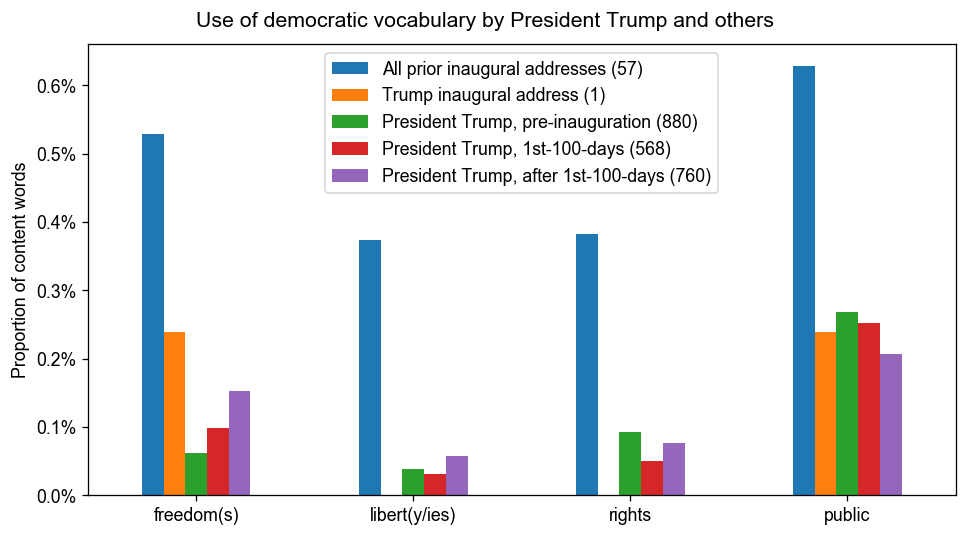

In [31]:
group_descriptions = {group.name: group.description for group in groups}
ax = df_pivot.rename(columns=group_descriptions).plot(figsize=(8.5, 4.5), kind='bar')
ax.xaxis.label.set_visible(False)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.01%}'.format(y)))
legend = ax.legend()
legend.set_title(None)
# plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.legend(loc='best')
plt.xticks(rotation=0)
plt.ylabel('Proportion of content words')
plt.suptitle('Use of democratic vocabulary by President Trump and others', y=1.02)
# plt.title('(bootstrapping seed terms with top 10 collocations in each group)')
plt.tight_layout()
# plt.savefig('democratic_vocabulary_proportions-bootstrapped.pdf')

In [22]:
# def iter_synsets_bootstrapped(speeches, synsets, n):
#     collocation_mapping = dict(nlp.sentence_collocation_mapping(speech.document for speech in speeches))
#     for synset_name, synset_tokens in synsets:
#         for bootstrapped_token in nlp.bootstrap_strings(synset_tokens, collocation_mapping, n):
#             yield synset_name + ' = ' + ', '.join(synset_tokens), bootstrapped_token
# df_bootstrapped = pd.DataFrame(iter_synsets_bootstrapped(inaugurals.speeches, focus_synsets, 10),
#                                columns=['synset', 'bootstrapped_token'])
# df_bootstrapped.set_index(['synset', 'bootstrapped_token'])
# df_bootstrapped.pivot(columns='synset', values='bootstrapped_token')

# Trump over time

In [197]:
pd.options.display.max_rows = 20

In [223]:
def create_and_plot_timeseries_df(df, values='synset_proportion_smoothed', columns='synset', ax=None):
    df_pivot = df.reset_index().pivot_table(values=values, index='timestamp', columns=columns)
    ax = df_pivot.plot(kind='line', ax=ax, grid=True)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.02%}'.format(y)))
    ax.legend(loc='best').set_title(None)
    #ax.set_xlabel('Speech date')
    ax.set_ylabel('Percentage of content words')
    return df_pivot

In [145]:
# focus_synset_names = {
#     'freedom(s)', 'libert(y/ies)', 'rights', 'public',
#     #'america(n(s))', 'job(s)',
# }
# focus_synsets = [(synset_name, synset_tokens) for synset_name, synset_tokens in synsets
#                  if synset_name in focus_synset_names]

In [23]:
# groups_lookup['election2016_speeches_trump']

In [24]:
# focus_synsets

In [213]:
df_speeches = create_speech_synset_df(groups_lookup['election2016_speeches_trump'].speeches, focus_synsets)
df_speeches = df_speeches.sort_values('timestamp')
df_speeches = df_speeches.reset_index().set_index(['synset', 'source'], verify_integrity=True)

In [221]:
# df_speeches

In [226]:
smoothing_window = 10
df_speeches['synset_proportion_smoothed'] = df_speeches.groupby(level='synset', group_keys=False).apply(
    lambda g: g.synset_proportion.rolling(smoothing_window, min_periods=1, center=True).mean()
)

In [228]:
timestamp_counts = df_speeches.reset_index().drop_duplicates(['source']).groupby('timestamp').size()
# timestamp_counts

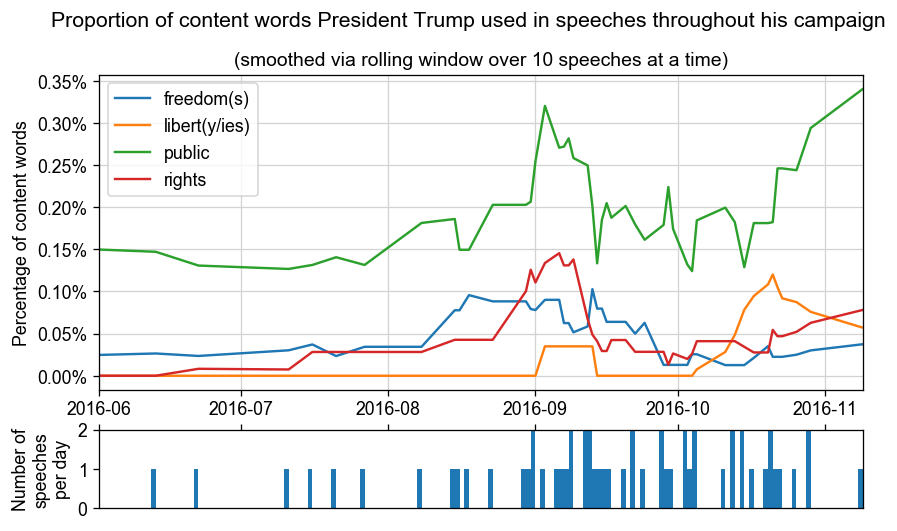

In [229]:
fig = plt.figure()#figsize=(12,5))
grid = mgridspec.GridSpec(nrows=2, ncols=1, height_ratios=[4, 1])

# produce top synsets plot
synset_ax = fig.add_subplot(grid[0])
synset_ax.tick_params(labelbottom='off')
synset_ax.xaxis.label.set_visible(False)
create_and_plot_timeseries_df(df_speeches, ax=synset_ax)
synset_ax.set_title('(smoothed via rolling window over %d speeches at a time)' % smoothing_window, {'fontsize': 12})

# produce bottom daily speeches plot
daily_ax = fig.add_subplot(grid[1])
daily_ax.xaxis.tick_top()
# for a bar plot, width=-1, align='edge' is like width=1, align='right' except 'right' isn't a valid align value
daily_ax.bar(timestamp_counts.index, timestamp_counts.values, width=-1, align='edge') # width is in days?
daily_ax.set_ylabel('Number of\nspeeches\nper day')

# trim axes the same
min_x = pd.to_datetime('2016-06-01')
max_x = pd.to_datetime('2016-11-09')
synset_ax.set_xlim(min_x, max_x)
daily_ax.set_xlim(min_x, max_x)
daily_ax.set_ylim(None, 2)

plt.suptitle('Proportion of content words President Trump used in speeches throughout his campaign')
# fig.tight_layout()

# Significant others

In [20]:
pd.options.display.max_rows = 20

In [21]:
def draw_positive_axes(plt=plt):
    #plt.plot([0, plt.xlim()[1]], [0, plt.ylim()[1]])
    plt.vlines(0, 0, 1, alpha=0.25)
    plt.hlines(0, 0, 1, alpha=0.25)

def hide_spines(ax=None):
    if ax is None:
        ax = plt.gca()
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)

In [22]:
# We'll be dealing with a lot of numbers. Let's discretize.
# 
# ('Most presidential', '2nd-most presidential', '3rd-most presidential', 
#  'Neutral', '3rd-most Trumpy', '2nd-most Trumpy', 'Most Trumpy')
_ordinals = {0: '1st', 1: '2nd', 2: '3rd'}
def _ordinal_string(i):
    return _ordinals.get(i, '{}th'.format(i - 1))
def _most_string(i):
    return 'Most' if i == 0 else '{}-most'.format(_ordinal_string(i))
def add_discretized(df, nbins=7,
                    sort_column='trump°inaugural',
                    discretized_column='trumpiness',
                    low_name='presidential', 
                    high_name='Trumpy'):
    '''
    Having an ordering on the words means we can bin the words in discrete chunks.

    The `trump/inaugural` ratio is monotonic with the `trump°inaugural` column, 
    but since the latter has a nicer scale, we'll use it.
    '''
    raise NotImplemented
    # equal bin widths:
    # _, binedges = np.histogram(df_proportions['x°y'], bins=nbins)
    # equal bin depths:
    binedges = np.percentile(df[sort_column], np.linspace(0, 100, nbins + 1))
    assignments = np.digitize(df[sort_column], binedges[:-1]) - 1
    # generate bin names
    low_names = ['{} {}'.format(_most_string(i), low_name) for i in range(nbins // 2)]
    high_names = ['{} {}'.format(_most_string(i), high_name) for i in range(nbins // 2)]
    binnames = low_names + ['Neutral'] + reverse(high_names)
    df[discretized_column] = np.array(binnames)[assignments]
    bins = [(name, pd.Series(list(group_df.sort_values(sort_column, ascending=True).word)))
                       for name, group_df in df.reset_index().groupby(discretized_column)]
    df_bins = pd.DataFrame(dict(bins)).fillna('')
    df_bins = df_bins[binnames]

In [32]:
from spacy import attrs
d = nlp("I've got to go.")
for k, v in d.count_by(attrs.LEMMA).items():
    print(k, nlp.vocab[k].orth_, is_word(k), v)
# for lex in list(nlp(s))[:100]:    
#     print(lex.orth_, lex.lemma_)

578 go False 1
419 . False 1
484 have False 1
518 get False 1
468 to False 1
1500059 -PRON- False 1


In [33]:
def iter_speeches_counts(speeches):
    '''
    speeches is a list of Speech instances
    return tuples of (group_name, word, count), where each (group_name, word) is unique
    '''
    speech_counts = [Counter(speech.lemma_counts) for speech in speeches]
    total_counts = reduce(operator.add, speech_counts)
    for lexeme_id, count in total_counts.items():
        yield nlp.vocab[lexeme_id].orth_, count

In [34]:
def create_df_groups(group_x, group_y):
    '''
    groups is a list of Group instances
    '''
    df_x = pd.DataFrame(iter_speeches_counts(group_x.speeches), columns=['word', 'word_count'])
    df_x['group'] = 'x'
    df_y = pd.DataFrame(iter_speeches_counts(group_y.speeches), columns=['word', 'word_count'])
    df_y['group'] = 'y'
    return pd.concat([df_x, df_y])

def create_df_pivot_proportions(df, word_count_smoothing=1):
    # That's nice to look at, but we also want some consistent ordering of relative
    # inaugural-ness vs. Trumpery. We can get that just by dividing one over the other. 
    # We'll use Trump proportion / Inaugural proportion, so higher values will indicate higher Trumpery.
    df_pivot_counts = df.pivot(index='word', columns='group', values='word_count').fillna(0) + word_count_smoothing
    df_pivot_proportions = df_pivot_counts / df_pivot_counts.sum()
    df_pivot_proportions['x/y'] = df_pivot_proportions.x / df_pivot_proportions.y
    # The ratio produces the desired ordering, but it ranges from very tiny values,
    # to 1 (meaning similar usage), to arbitrarily large values.
    # As we'll seen in a second with the (log-log) scatter plot, what we want is 
    # a sort of radial / angular measure. The words around the y=x diagonal see 
    # similar usage, with the words in the upper-left being more Trump-ish and 
    # the words in the lower-right being more Inaugural.
    rad = np.arctan2(df_pivot_proportions.x, df_pivot_proportions.y)
    # re-map from [0, pi/2] to [-1, 1]
    df_pivot_proportions['x°y'] = rad * (4.0 / np.pi) + -1.0
    return df_pivot_proportions.sort_values('x°y')

In [35]:
group_x = groups_lookup['inaugurals_pretrump']
group_y = groups_lookup['election2016_speeches_trump']
# group_y = groups_lookup['inaugurals_trump']
df_groups = create_df_groups(group_x, group_y)
# df_groups

In [36]:
df_proportions = create_df_pivot_proportions(df_groups, 1)
# df_proportions

# Focus

How about we focus in on a couple specific words.

In [37]:
extremes_k = 20
extremes_vocab = set(df_proportions.head(extremes_k).index) | set(df_proportions.tail(extremes_k).index)
keywords_vocab = {'freedom', 'freedoms', 'liberty', 'liberties', 'rights', 'justice',
                  'borders', 'protected', 'jobs', 'families', 'factories', 'wealth'}
# derive more condensed vocabulary
df_counts_combined = df_groups.groupby('word').aggregate({'word_count': sum})
common_k = 5000
common_vocab = set(df_counts_combined.nlargest(common_k, 'word_count').index)
commonest_k = 25
commonest_vocab = set(df_counts_combined.nlargest(commonest_k, 'word_count').index)
# print('|vocab| =', len(commonest_vocab), '; commonest_vocab:', ' '.join(commonest_vocab))

In [46]:
# limit to subset of vocab and max values
labeled_vocab = extremes_vocab | keywords_vocab | set(democratic_vocab) | set(authoritarian_vocab) | commonest_vocab
subset_vocab = labeled_vocab | common_vocab
df_proportions_subset = df_proportions[df_proportions.index.isin(subset_vocab)]

In [60]:
print('extremes: {}'.format(', '.join("'{}'".format(w) for w in extremes_vocab)))
print('keywords: {}'.format(', '.join("'{}'".format(w) for w in keywords_vocab)))
print('democratic: {}'.format(', '.join("'{}'".format(w) for w in democratic_vocab)))
print('authoritarian: {}'.format(', '.join("'{}'".format(w) for w in authoritarian_vocab)))

extremes: 'preserve', 'mike', 'iran', 'trump', 'shall', 'expenditure', 'percent', 'arise', 'honorable', 'islamic', 'donald', 'discharge', 'wise', 'faithful', 'countryman', 'clinton', 'endeavor', 'inaudible', 'obama', 'counsel', 'terrorist', 'isis', 'applause', 'sentiment', 'nafta', 'solemn', 'refugee', 'trillion', 'obamacare', 'hillary', 'almighty', 'amazing', 'maintain', 'passion', 'progress', 'section', 'donor', 'email', 'exercise', 'ideal'
keywords: 'jobs', 'wealth', 'rights', 'justice', 'freedom', 'liberty', 'liberties', 'freedoms', 'protected', 'families', 'borders', 'factories'
democratic: 'peace', 'constitution', 'liberty', 'public', 'government', 'freedom', 'free', 'good', 'hope', 'justice', 'united', 'citizen', 'right'
authoritarian: 'duty', 'war', 'force', 'secure', 'law', 'power', 'national', 'strength', 'foreign', 'control', 'defend', 'military', 'safe', 'triumph', 'fight protect', 'victory', 'border', 'job', 'steal'


In [57]:
# keywords_vocab - (set(democratic_vocab) | set(authoritarian_vocab))

In [ ]:
print('extremes: {}'.format(', '.join(extremes_vocab)))

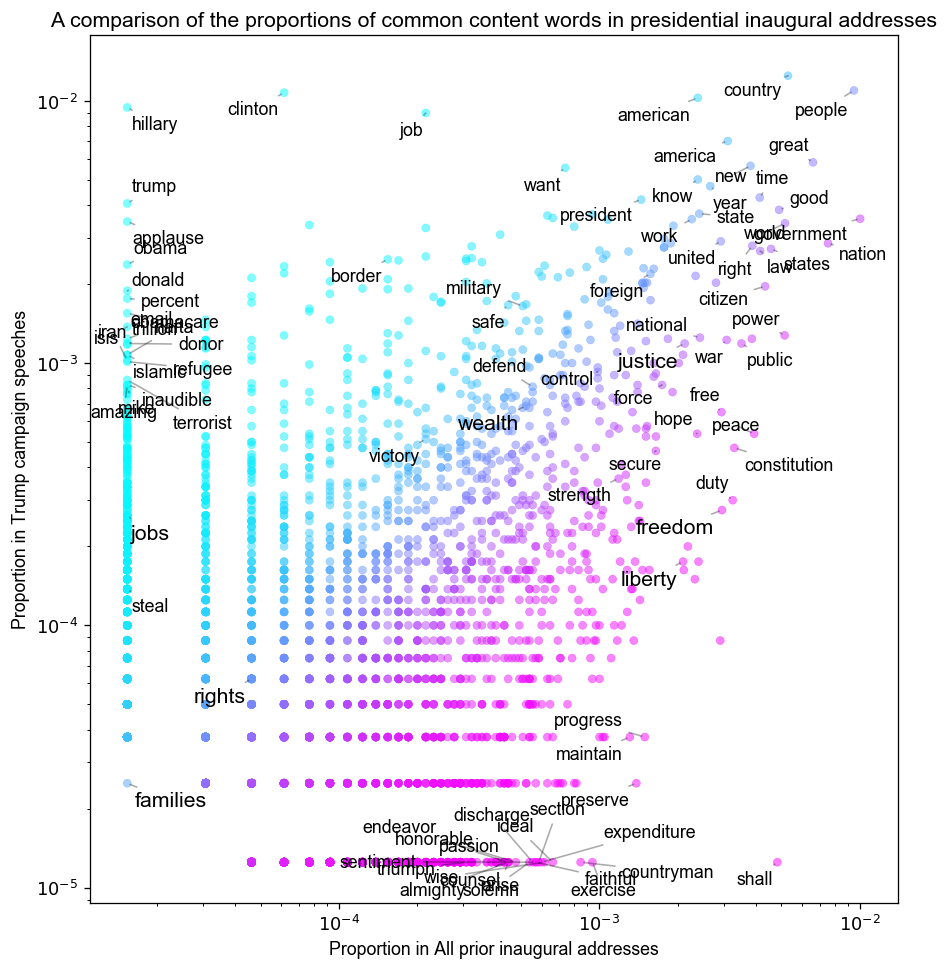

In [58]:
plt.figure(figsize=(8.5, 8.5))
xs = df_proportions_subset.x #- min(df_proportions_subset.inaugurals_pretrump)
plt.xlabel('Proportion in {}'.format(group_x.fullname))
ys = df_proportions_subset.y #- min(df_proportions_subset.inaugurals_trump)
plt.ylabel('Proportion in {}'.format(group_y.fullname))
# 
plt.yscale('log')
plt.xscale('log')
plt.scatter(xs, ys, 
            c=df_proportions_subset['x°y'], 
            cmap=plt.cm.cool, #c='#27BC8A',
            linewidths=.3, s=25, alpha=0.5)
# labels
annotations = []
for index, (label, x, y) in enumerate(zip(df_proportions_subset.index, xs, ys)):
    if label in labeled_vocab:
        size = 'large' if label in keywords_vocab else None
        annotation = plt.text(x, y, label, size=size)
        annotations.append(annotation)
# adjustments
adjust_text(annotations, force_text=0.012, 
            expand_points=(1.2, 1.75), force_points=0.4,
            arrowprops=dict(arrowstyle="-", color='k', alpha=0.33), lim=1000)
# hide_spines()
# draw_positive_axes()
plt.title('A comparison of the proportions of common content words in presidential inaugural addresses')
# xmax = 0.25
# ymax = 0.25
# plt.xlim(-0.004, xmax)
# plt.ylim(-0.001, ymax)
# add %-age ticks
ax = plt.gca()
# ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
# plt.xticks(np.arange(0, plt.xlim()[1], 0.01))
# plt.yticks(np.arange(0, plt.ylim()[1], 0.01))
plt.tight_layout()
# plt.savefig('inaugural_campaign_scatter_labeled_log_log.pdf')

In [59]:
df_proportions_export = df_proportions_subset[
    ['x', 'y', 'x°y']
].rename(columns={'x': group_x.name,
                  'y': group_y.name,
                  'x°y': 'arctan2({},{})'.format(group_x.name, group_y.name)})
# df_proportions_export.to_csv('inaugural_campaign_scatter_labeled_log_log.csv', encoding='utf-8')